In [7]:
import nashpy as nash
import numpy as np
from scipy.special import softmax
from scipy.stats import entropy
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt

from simu import *

import seaborn as sns
sns.set_theme()
sns.set_context("notebook")
import matplotlib.pyplot as plt
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [8]:
def expected_utility_player_i(Phi, strategies, i):
    """
    Compute expected utility vector u_i ∈ R^A for player i.
    
    Args:
        Phi: N-dimensional tensor of shape (A, ..., A)
        strategies: list of N arrays of length A (current marginals)
        i: index of player (0-based)
        
    Returns:
        u_i: expected utility for each action a_i ∈ A
    """
    A = strategies[0].shape[0]
    N = len(strategies)
    u_i = np.zeros(A)

    other_indices = [j for j in range(N) if j != i]

    for a_i in range(A):
        # Fix action a_i for player i
        slices = [slice(None)] * N
        slices[i] = a_i
        Phi_slice = Phi[tuple(slices)]

        # Marginalize over a_{-i}
        weights = strategies[0]
        for j in other_indices:
            weights = np.tensordot(weights, strategies[j], axes=0)

        u_i[a_i] = np.sum(Phi_slice * weights)

    return u_i


def seob_strategy_per_it(u, p_init, marginal='exponential', params=None, step_size=0.01):
    """
    Compute the SE-OB strategy for a given utility vector u.
    
    Args:
        u: 1D array of expected payoffs (shape: [K])
        marginal: 'exponential', 'uniform', or 'tsallis'
        params: dict of parameters, e.g., {'eta': ..., 'gamma': ..., 'q': ...}
        
    Returns:
        p: SE-OB strategy (array of shape [K])
    """

    def proj_simplex(x):
        sorted_x = np.sort(x)[::-1]
        cumsum = np.cumsum(sorted_x)
        rho = np.where(sorted_x > (cumsum - 1) / (np.arange(K) + 1))[0][-1]
        theta = (cumsum[rho] - 1) / (rho + 1)
        return np.maximum(x - theta, 0)

    u = np.array(u)
    K = len(u)
    N = len(p_init)
    
    if params is None:
        params = {}

    if marginal == 'exponential':
        # τ_i ∝ η_i * exp(u_i / γ)
        eta = params.get('eta', np.ones(K))
        gamma = params.get('gamma', 1.0)
        logits = eta * np.exp(u / gamma)
        p = logits / logits.sum()

    elif marginal == 'uniform':
        # τ = sparsemax(u / γ)
        gamma = params.get('gamma', 1.0)
        # v = (u / gamma + 1)/(2*K)
        # p = sparsemax(v)

        # Closed-form solution doesn't exist; use projected gradient ascent
        def objective(p):
            v = (u/gamma + 1) / (2 * N)
            return -np.sum((p - v)**2)
        
        def grad(p):
            v = (u/gamma + 1) / (2 * N)
            return - 2 * (p - v)


        p = p_init.copy() if p_init is not None else np.ones(K) / K
        for _ in range(1):
            p += step_size * grad(p)
            p = proj_simplex(p)


    elif marginal == 'tsallis':
        # Solve: max_{p in simplex} <p, u> - γ/(q-1) * sum_i η_i [(p_i/η_i)^q - (p_i/η_i)]
        eta = params.get('eta', np.ones(K))
        gamma = 2.0 * params.get('gamma', 1.0)
        q = params.get('q', 2.0)

        # Closed-form solution doesn't exist; use projected gradient ascent
        def objective(p):
            term1 = np.dot(p, u)
            term2 = - gamma * (1/(q - 1)) * np.sum(eta * ((p / eta) ** q - (p / eta)))
            return term1 + term2
        
        def grad(p):
            return u - gamma * q * ((p / eta) ** (q - 1)) / (q - 1) + gamma / (q - 1)


        p = p_init.copy() if p_init is not None else np.ones(K) / K
        for _ in range(1):
            p += step_size * grad(p)
            p = proj_simplex(p)

    else:
        raise ValueError(f"Unknown marginal: {marginal}")
    
    return p


def random_simplex_vector(K):
        x = np.random.rand(K)
        return x / x.sum()


def compute_seob_equilibrium_N(Phi, marginal='exponential', params=None, step_size=0.01,
                               max_iter=1000, tol=1e-5, verbose=False):
    """
    Compute SE-OB equilibrium strategies for an N-player potential game.

    Args:
        Phi: potential function tensor of shape (A, A, ..., A) (length N)
        marginal: marginal belief model ('exponential', etc.)
        params: dict of parameters for SE-OB
        step_size: for tsallis projection
        max_iter: max number of iterations
        tol: convergence threshold
        
    Returns:
        strategies: list of N arrays of length A (strategy marginals)
    """
    N = Phi.ndim
    A = Phi.shape[0]
    

    strategies = [random_simplex_vector(A) for _ in range(N)]

    for it in range(max_iter):
        new_strategies = []
        for i in range(N):
            u_i = expected_utility_player_i(Phi, strategies, i)
            p_init = strategies[i]
            new_p = seob_strategy_per_it(u_i, p_init, marginal, params, step_size)
            new_strategies.append(new_p)

        delta = sum(np.linalg.norm(new_strategies[i] - strategies[i]) for i in range(N))
        if verbose:
            print(f"Iter {it}: delta = {delta:.3e}")
        if delta < tol:
            break

        strategies = new_strategies

    return strategies


In [9]:
import numpy as np
from scipy.stats import beta

def generate_potential_game(N=4, A=20, seed=None):
    """
    Generate a potential game with N agents and A actions per agent.

    Returns:
        Phi: array of shape (A^N,) with values drawn from Beta(0.5, 0.5)
        Phi_tensor: N-dimensional tensor of shape (A, A, ..., A) representing the potential
    """
    if seed is not None:
        np.random.seed(seed)

    joint_action_space = A ** N
    Phi_flat = 20 * beta.rvs(a=2, b=2, size=joint_action_space)
    Phi_tensor = Phi_flat.reshape((A,) * N)
    return Phi_tensor


def get_agent_utilities_from_potential(Phi_tensor):
    """
    In a potential game, agent utilities are all equal to the potential.
    Returns a list of N utility tensors (same as Phi).
    """
    N = Phi_tensor.ndim
    return [Phi_tensor.copy() for _ in range(N)]


In [10]:
if __name__ == "__main__":
    N, A = 4, 20
    Phi = generate_potential_game(N, A, seed=1234)

    params = {'gamma': 5.0, 'eta': np.ones(A)}  # like τ = 1e-2
    # marginal='uniform'  # 'exponential', 'uniform', or 'tsallis'
    marginal = 'tsallis'  # Choose the marginal belief model
    
    # strategies_star = compute_seob_equilibrium_N(Phi, marginal='tsallis', params=params, verbose=True)
    strategies_star = compute_seob_equilibrium_N(Phi, marginal=marginal, params=params, verbose=True)

    # # Compute expected potential value
    # joint_dist = strategies[0]
    # for i in range(1, N):
    #     joint_dist = np.tensordot(joint_dist, strategies[i], axes=0)
    # expected_potential = np.sum(joint_dist * Phi)
    # print("\nExpected potential value under SE-OB equilibrium:", expected_potential)
    for i, strat in enumerate(strategies_star):
        print(f"Player {i} strategy (top 5 actions):", np.round(strat[:5], 3))

Iter 0: delta = 1.029e-01
Iter 1: delta = 8.185e-02
Iter 2: delta = 6.526e-02
Iter 3: delta = 5.215e-02
Iter 4: delta = 4.175e-02
Iter 5: delta = 3.347e-02
Iter 6: delta = 2.688e-02
Iter 7: delta = 2.161e-02
Iter 8: delta = 1.739e-02
Iter 9: delta = 1.401e-02
Iter 10: delta = 1.131e-02
Iter 11: delta = 9.129e-03
Iter 12: delta = 7.379e-03
Iter 13: delta = 5.970e-03
Iter 14: delta = 4.834e-03
Iter 15: delta = 3.918e-03
Iter 16: delta = 3.178e-03
Iter 17: delta = 2.580e-03
Iter 18: delta = 2.096e-03
Iter 19: delta = 1.704e-03
Iter 20: delta = 1.386e-03
Iter 21: delta = 1.129e-03
Iter 22: delta = 9.195e-04
Iter 23: delta = 7.496e-04
Iter 24: delta = 6.114e-04
Iter 25: delta = 4.989e-04
Iter 26: delta = 4.074e-04
Iter 27: delta = 3.329e-04
Iter 28: delta = 2.721e-04
Iter 29: delta = 2.225e-04
Iter 30: delta = 1.820e-04
Iter 31: delta = 1.490e-04
Iter 32: delta = 1.220e-04
Iter 33: delta = 9.996e-05
Iter 34: delta = 8.192e-05
Iter 35: delta = 6.717e-05
Iter 36: delta = 5.509e-05
Iter 37: de

In [11]:
N = Phi.ndim
A = Phi.shape[0]

strategies = [random_simplex_vector(A) for _ in range(N)]
d_seq = []

max_iter = 50
ss = 2e-2

for it in range(max_iter):

    d_new = [np.linalg.norm(strategies[i] - strategies_star[i]) for i in range(N)]
    d_seq.append(d_new)

    # step_size = 2e-1 / (it + 1)
    step_size = ss
    new_strategies = []
    for i in range(N):
        u_i = expected_utility_player_i(Phi, strategies, i)
        p_init = strategies[i]
        new_p = seob_strategy_per_it(u_i, p_init, marginal, params, step_size)
        new_strategies.append(new_p)
    strategies = new_strategies


```markdown
|-------------------------|--------|--------|---------|---------|----|----|----|----|----|----|
| Iteration               | 0      | 5      | 10      | 15      | 20 | 25 | 30 | 35 | 40 | 45 |
| $\|p_1^{(t)} - p_1^*\|$ | 0.1612 | 0.0142 |  0.0014 |  0.0001 |  0 |  0 |  0 |  0 |  0 |  0 |
| $\|p_2^{(t)} - p_2^*\|$ | 0.0911 | 0.0094 |  0.001  |  0.0001 |  0 |  0 |  0 |  0 |  0 |  0 |
| $\|p_3^{(t)} - p_3^*\|$ | 0.1301 | 0.0116 |  0.0012 |  0.0001 |  0 |  0 |  0 |  0 |  0 |  0 |
| $\|p_4^{(t)} - p_4^*\|$ | 0.1409 | 0.0113 |  0.001  |  0.0001 |  0 |  0 |  0 |  0 |  0 |  0 |
```


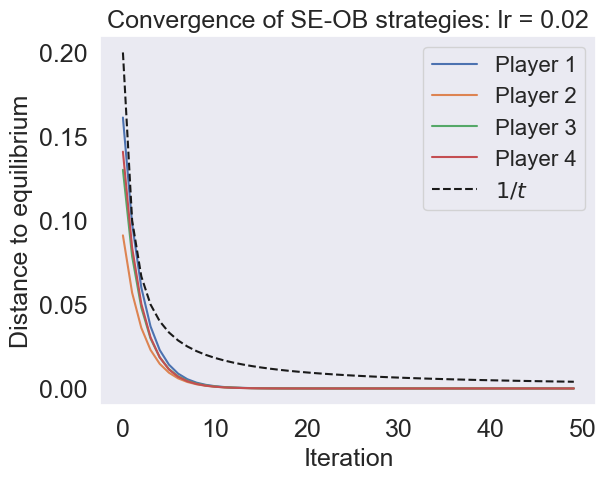

In [12]:
c = 2e-1
A = 5

from tabulate import tabulate

table = [
    ["Iteration"] + [str(i) for i in np.arange(0,len(d_seq),A)],
    [r"$\|p_1^{(t)} - p_1^*\|$"] + [f"{d_seq[i][0]:.4f}" for i in np.arange(0,len(d_seq),A)],
    [r"$\|p_2^{(t)} - p_2^*\|$"] + [f"{d_seq[i][1]:.4f}" for i in np.arange(0,len(d_seq),A)],
    [r"$\|p_3^{(t)} - p_3^*\|$"] + [f"{d_seq[i][2]:.4f}" for i in np.arange(0,len(d_seq),A)],
    [r"$\|p_4^{(t)} - p_4^*\|$"] + [f"{d_seq[i][3]:.4f}" for i in np.arange(0,len(d_seq),A)]
]

print("```markdown")
print(tabulate(table, tablefmt="github"))
print("```")

plt.plot(np.arange(len(d_seq)), [d[0] for d in d_seq], label='Player 1')
plt.plot(np.arange(len(d_seq)), [d[1] for d in d_seq], label='Player 2')
plt.plot(np.arange(len(d_seq)), [d[2] for d in d_seq], label='Player 3')
plt.plot(np.arange(len(d_seq)), [d[3] for d in d_seq], label='Player 4')
plt.plot(np.arange(len(d_seq)), c / np.arange(1,1+len(d_seq)), 'k--', label=r'$1/t$')
plt.xlabel('Iteration')
plt.ylabel('Distance to equilibrium')
plt.title('Convergence of SE-OB strategies: lr = {:.2f}'.format(ss))
plt.legend()
plt.grid()
plt.show()